In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from lib.dataset_utils import *
from lib.mnist_model import *
from lib.cwl2_attack import CWL2Attack

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
exp_id = 0

model_name = 'mnist_exp%d.h5' % exp_id
net = BasicModel()

In [5]:
# Set all random seeds
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set up model directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

net = net.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
net.load_state_dict(torch.load(model_path))
# net = net.module
# net = net.basic_net
net.eval()

BasicModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (relu2): ReLU(inplace)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace)
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (relu4): ReLU(inplace)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (relu5): ReLU(inplace)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
(x_train, y_train), (x_valid, y_valid), (x_test, y_test) = load_mnist_all(
    '/data', val_size=0.1, seed=seed)

In [8]:
def classify(net, x):
    
    with torch.no_grad():
        y_pred = torch.zeros((x.size(0), 10))
        num = 0
        i = -1
        for i in range(x.size(0) // 100):
            begin = i * 100
            end = (i + 1) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
        if (x.size(0) // 100) * 100 != x.size(0):
            begin = (i + 1) * 100
            end = (i + 2) * 100
            y_pred[begin:end] = net(x[begin:end].to('cuda'))
    return y_pred

In [9]:
y_pred = classify(net, x_test)
correct_idx = (y_pred.argmax(1).cpu() == y_test).numpy()
correct_idx = np.where(correct_idx)[0]
print('Test acc:', len(correct_idx) / y_test.size(0))

Test acc: 0.993


---

## Isotropic Gaussian Noise

1 random noise per sample

In [10]:
std = 0.2

In [12]:
acc = []
stds = 10 ** np.arange(-2, 0, 0.1)

for std in stds:
    with torch.no_grad():
        rnd = torch.randn_like(x_test) * std
        x_rnd = torch.clamp(x_test + rnd, 0, 1)
        y_pred = classify(net, x_rnd)
        acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

In [81]:
acc = []
stds = 10 ** np.arange(-2, 1, 0.1)

for std in stds:
    
    with torch.no_grad():
        rnd = torch.randn_like(x_test) * std
        y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
        acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))

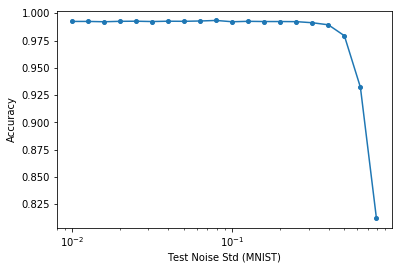

In [13]:
plt.plot(stds, acc, 'o-', markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (MNIST)')
plt.ylabel('Accuracy')
plt.show()

In [10]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(6):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            x_rnd = torch.clamp(x_test.cuda() + rnd.cuda(), 0, 1)
            y_pred = net(x_rnd).cpu()
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

In [11]:
train_std = [0, 5e-2, 1e-1, 5e-1, 1, 2]

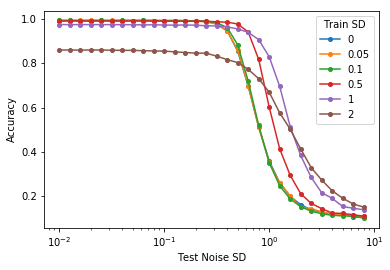

In [13]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise SD')
plt.ylabel('Accuracy')
plt.legend(title='Train SD')
plt.show()

In [ ]:
# This is not the best way to measure robustness because clean acc without noise
# varies significantly between models

In [14]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(6):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = net(x_test.cuda()).cpu()
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[correct_idx]) * std
            y_pred = net((x_test[correct_idx].cuda() + rnd.cuda()).clamp(0, 1)).cpu()
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

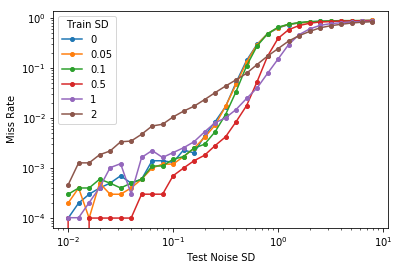

In [16]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), '-o', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise SD')
plt.ylabel('Miss Rate')
plt.legend(title='Train SD')
plt.show()

In [18]:
# Test Hypothesis (3)

accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(6):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = net(x_test.cuda()).cpu()
        inc_idx = np.where(y_pred.argmax(1) != y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[inc_idx]) * std
            x_rnd = torch.clamp(x_test[inc_idx] + rnd, 0, 1).cuda()
            y_pred = net(x_rnd).cpu()
            acc.append((y_pred.argmax(1) == y_test[inc_idx]).sum().numpy() / len(inc_idx))
            
    accs.append(acc)

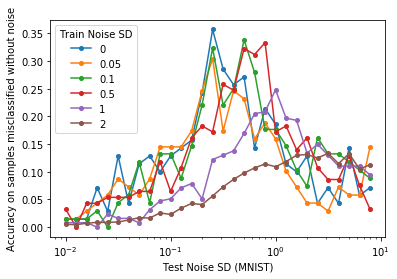

In [19]:
for i, acc in enumerate(accs):
    plt.plot(stds, np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise SD (MNIST)')
plt.ylabel('Accuracy on samples misclassified without noise')
plt.legend(title='Train Noise SD')
plt.show()

In [ ]:
# Model trained with std of 2 is most robust to large noise but least robust to small noise
# It has significantly lower clean accuracy compared to the rest of the models, however.
# This may suggest that it learns something significantly different.
# The rest of the models are more similar, but the same effects are there, e.g. 
# 1-model is a little less robust to 0.1-noise than 0.5-model

# However, we have to be careful here. We need to repeat experiments multiple times
# and report mean with error bar

1 random noise per sample with clamp

In [187]:
train_std = [0, 0.1, 0.2, 0.5, 1, 1.5, 2]

In [186]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(7):
    
    if i != 0:
        i += 12
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

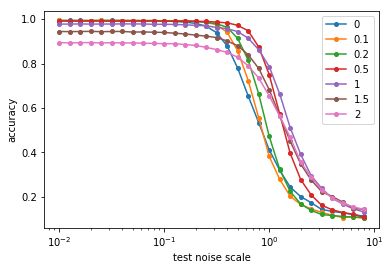

In [188]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.xlabel('test noise scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [189]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(7):
    
    if i != 0:
        i += 12
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = net(x_test.cuda()).cpu()
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[correct_idx]) * std
            y_pred = net(x_test[correct_idx].cuda() + rnd.cuda()).cpu()
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

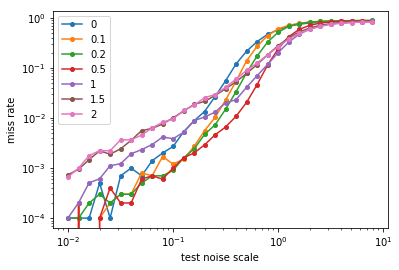

In [190]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('test noise scale')
plt.ylabel('miss rate')
plt.legend()
plt.show()

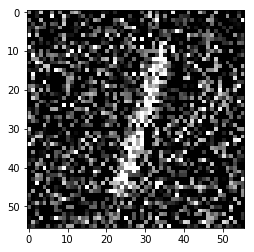

In [34]:
std = 0.5
rnd = torch.randn(x_test[0].size()) * std
plt.imshow(torch.clamp(x_test[2] + rnd, 0, 1).squeeze().numpy(), cmap='gray')
plt.show()

N random noises per sample

In [ ]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.2)
num_rnd = 1e2

for i in range(4):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        print(std)
        start_time = time.time()
        acc_sum = 0
        for j in range(x_test.size(0)):
            with torch.no_grad():
                rnd = torch.randn((int(num_rnd), 1, 28, 28)) * std
                y_pred = net(x_test[j].cuda() + rnd.cuda()).cpu()
                acc_sum += ((y_pred.argmax(1) == y_test[j]).sum().numpy() / num_rnd)
        acc.append(acc_sum / x_test.size(0))
        print(time.time() - start_time)
    accs.append(acc)

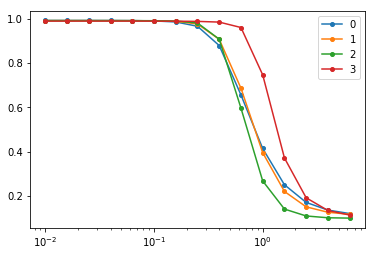

In [106]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=i, markersize=4)
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
# drawing multiple random noises per sample seem to do about the same
# as drawing only one -- on expectation

---

## Uniform Noise

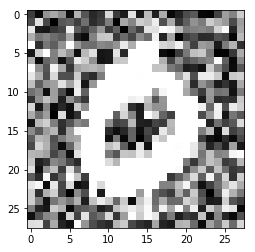

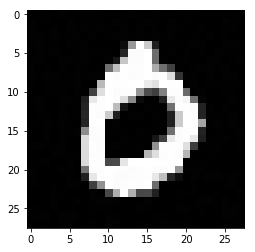

In [175]:
std = 1
rnd = torch.rand((1, 28, 28)) * std
plt.imshow(torch.clamp(x_test[3] + rnd, 0, 1).squeeze().numpy(), cmap='gray')
plt.show()

std = 0.01
rnd = torch.rand((1, 28, 28)) * std
plt.imshow(torch.clamp(x_test[3] + rnd, 0, 1).squeeze().numpy(), cmap='gray')
plt.show()

In [121]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(8):
    
    if i != 0:
        i += 5
        
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.rand_like(x_test) * std
            y_pred = net(x_test.cuda() + rnd.cuda()).cpu()
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

In [150]:
train_std = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]

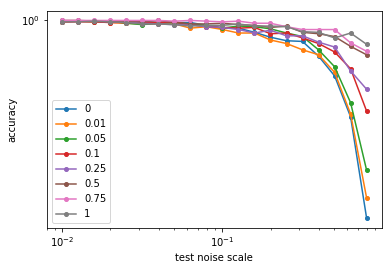

In [159]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('test noise scale')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [148]:
accs = []
stds = 10 ** np.arange(-2, 0, 0.1)

for i in range(8):
    
    if i != 0:
        i += 5
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = net(x_test.cuda()).cpu()
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.rand_like(x_test[correct_idx]) * std
            y_pred = net(x_test[correct_idx].cuda() + rnd.cuda()).cpu()
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

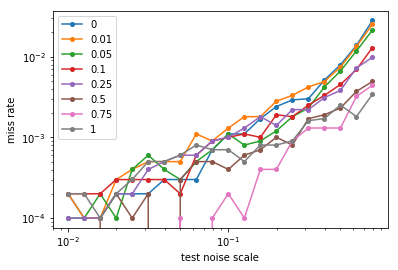

In [157]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('test noise scale')
plt.ylabel('miss rate')
plt.legend()
plt.show()

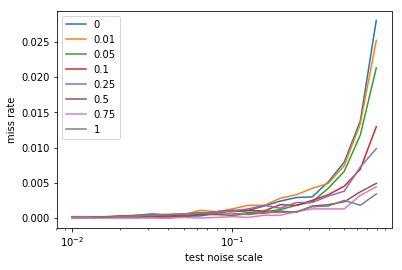

In [158]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), '-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('test noise scale')
plt.ylabel('miss rate')
plt.legend()
plt.show()

In [24]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(22, 28):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    acc = []
    for std in stds:
        with torch.no_grad():
            rnd = torch.randn_like(x_test) * std
            x_rnd = torch.clamp(x_test + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test).sum().numpy() / y_test.size(0))
    accs.append(acc)

In [25]:
train_std = [0.2, 0.5, 1, 0, 1.5, 1.75]

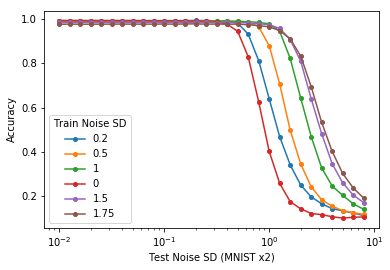

In [26]:
for i, acc in enumerate(accs):
    plt.plot(stds, acc, 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise SD (MNIST x2)')
plt.ylabel('Accuracy')
plt.legend(title='Train Noise SD')
plt.show()

In [28]:
accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(22, 28):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        correct_idx = np.where(y_pred.argmax(1) == y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[correct_idx]) * std
            x_rnd = torch.clamp(x_test[correct_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[correct_idx]).sum().numpy() / len(correct_idx))
            
    accs.append(acc)

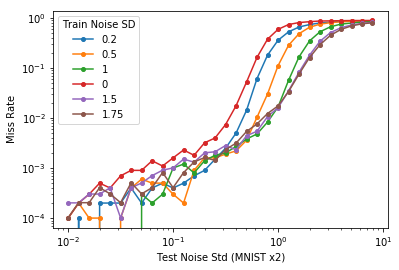

In [29]:
for i, acc in enumerate(accs):
    plt.plot(stds, 1 - np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Test Noise Std (MNIST x2)')
plt.ylabel('Miss Rate')
plt.legend(title='Train Noise SD')
plt.show()

In [40]:
# Test Hypothesis (3)

accs = []
stds = 10 ** np.arange(-2, 1, 0.1)

for i in range(22, 28):
    
    model_name = 'mnist_exp%d.h5' % i
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    net.load_state_dict(torch.load(model_path))
    
    with torch.no_grad():
        y_pred = classify(net, x_test)
        inc_idx = np.where(y_pred.argmax(1) != y_test)[0]
    
        acc = []
        for std in stds:
            rnd = torch.randn_like(x_test[inc_idx]) * std
            x_rnd = torch.clamp(x_test[inc_idx] + rnd, 0, 1)
            y_pred = classify(net, x_rnd)
            acc.append((y_pred.argmax(1) == y_test[inc_idx]).sum().numpy() / len(inc_idx))
            
    accs.append(acc)

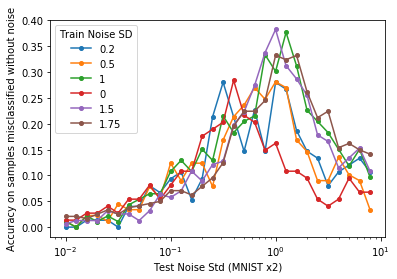

In [41]:
for i, acc in enumerate(accs):
    plt.plot(stds, np.array(acc), 'o-', label=train_std[i], markersize=4)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Test Noise Std (MNIST x2)')
plt.ylabel('Accuracy on samples misclassified without noise')
plt.legend(title='Train Noise SD')
plt.show()

In [ ]:
# Train: batch is 1 sample with n noises